## Decision Trees
- Can be applied to both regression and classification problems
- Advantages: Easily explainable, Graphically displayable, Natively handle qualitative predictors (without the need for encoding)
- Disadvantages: High variance (overfitting) (different subsets generate different results), Lower performance

---
#### Regression Tree
- For **CONTINUOUS** variables
- How to build a regression tree:
    - Split the predictor space (the possible values of the attributes $X_1,...,X_p$) into distinct and non-overlapping Regions $R_1, ..., R_J$, based on specific conditions (like $X_1 <3$, $X_2>5$, ...)
    - Consider the region $R_j$: take the mean ($\hat{y}_{R_j}$) of the response value (Y_train) for the training observations in $R_j$. **For every new/test sample that falls into region $R_j$, the prediction of the model (y_pred) is the mean value said above**.
    - The boundaries of the regions are theoretically the ones that minimize the RSS metric: $$ \underset{R_1, R_2, ..., R_J}{\text{argmin}} \sum_{j=1}^{J} \sum_{i \in R_j} (y_i - \hat{y}_{R_j})^2 $$
    where $\hat{y}_{R_j}$ is the mean response value for the training observations in $R_j$. 
    But it's computationally unfeasible to consider every possible combination, therefore it's used the **Recursive Binary Splitting**: this approach is top-down as it starts at the top of the tree (where all observations fall into a single region) and successively splits the predictor space into two new branches. It's greedy because, at each step, the algorithm chooses the best split at that particular region without consideration of the next steps.
        - At each step, the algorithm seeks for the predictor (variable $X_i$) and the cut point ($s$) defined like this: $$ R_1(j, s) = \{X|X_j \leq s\} \quad \text{and} \quad R_2(j, s) = \{X|X_j > s\} $$
        that lead to the greatest reduction in RSS equation: $$ \sum_{x_i \in R_1(j,s)} (y_i - \hat{y}_{R_1})^2 + \sum_{x_i \in R_2(j,s)} (y_i - \hat{y}_{R_2})^2 $$
        - Repeat the process until a stopping criterion, e.g.:
            - all node samples belong to the same attribute value
            - a region contains less than $Δ$ observations, or 
            - the RSS gain is less than $Φ$ or 
            - the iteration number is higher than $Υ$
        - Potentially you can make a tree where every sample is a leaf --> overfitting and time-consuming:
            - **(Post) Pruning** the tree: remove those branches that do not contribute significantly to the decision process, adding a "penalty" to the score function: $$ \text{minimize Tree Score} = \sum_{m=1}^{|T|} \sum_{x_i \in R_m} (y_i - \hat{y}_{R_m})^2 + \alpha|T| $$
            where $|T|$ is number of leafs, and $\alpha$ the tuning parameter that controls the tradeoff between subtree complexity and fit to training data

In [11]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mlxtend.plotting import plot_decision_regions
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import sklearn.tree as tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier


plt.style.use("seaborn-v0_8")
random_state = 42

,Features,Importances
3,Class,0.978877
0,Sepal Length,0.021123
1,Sepal Width,0.000000
2,Petal Width,0.000000


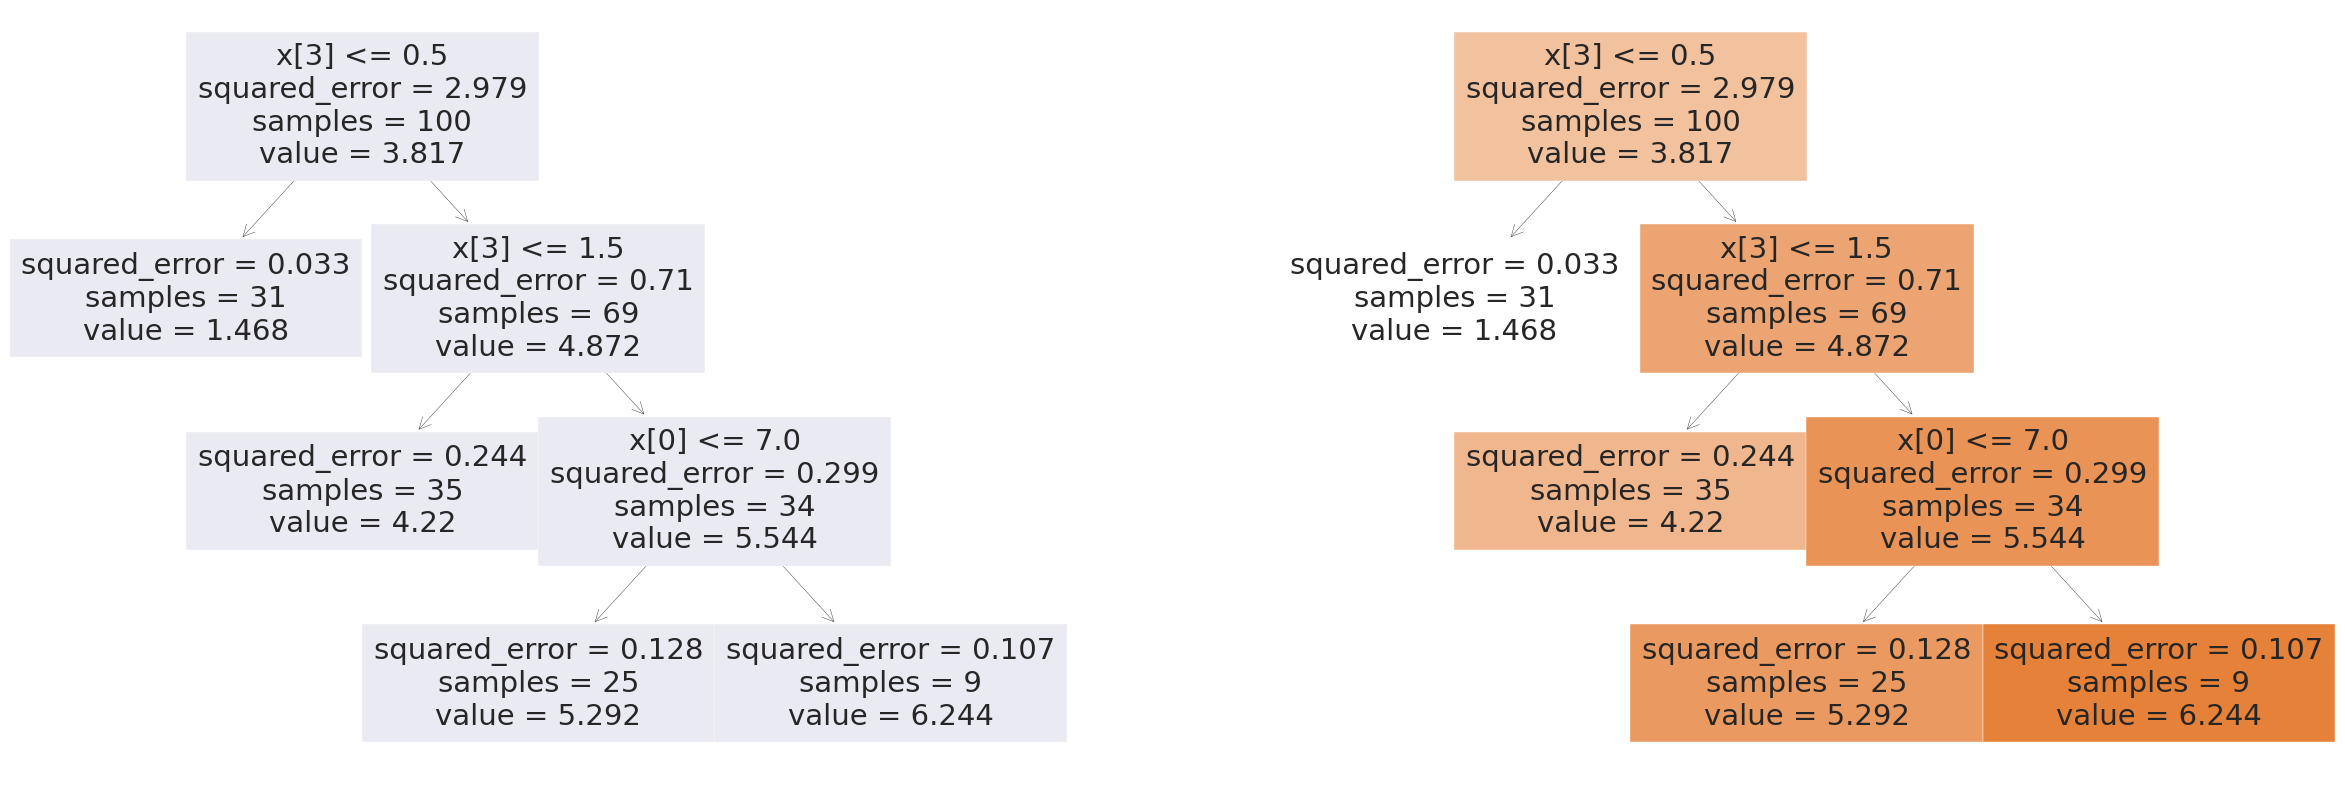

|--- feature_3 <= 0.50
|   |--- value: [1.47]
|--- feature_3 >  0.50
|   |--- feature_3 <= 1.50
|   |   |--- value: [4.22]
|   |--- feature_3 >  1.50
|   |   |--- feature_0 <= 7.00
|   |   |   |--- value: [5.29]
|   |   |--- feature_0 >  7.00
|   |   |   |--- value: [6.24]

Avg accuracy:  0.9710093826544693


In [12]:
df = pd.read_csv("datasets/iris.data.txt")
df_X = df.drop("Petal Length", axis=1)
# Predict a continuous variable
df_y = df["Petal Length"]

# Label Encoding
df_X["Class"] = LabelEncoder().fit_transform(df_X["Class"])

X_train, X_test, Y_train, Y_test = train_test_split(
    df_X, df_y, test_size=0.33, random_state=random_state
)

# Post Pruning with i.e. max_leaf_nodes
regr = DecisionTreeRegressor(
    criterion="squared_error", ccp_alpha=0.05, max_leaf_nodes=7
)
regr.fit(X_train, Y_train)

# Impurity-based feature importance
display(
    pd.DataFrame(
        {"Features": df_X.columns, "Importances": regr.feature_importances_}
    ).sort_values("Importances", ascending=False)
)

# Tree representation: every leaf is a region
# first line: test condition of X_j variable to calculate regions boundaries
# second line: error
# third line: number of train samples fallen in this node
# fourth line: *mean value* of the train samples in this node --> **for the leaf nodes it's the predicted value**
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))
tree.plot_tree(
    regr, filled=False, ax=ax1
)  # filled: not useful for continuous values, it colors the nodes according to node value
tree.plot_tree(regr, filled=True, ax=ax2)
plt.show()

# Text representation
text_representation = tree.export_text(regr)
print(text_representation)

# Prediction
regr.predict(X_test)
print("Avg accuracy: ", regr.score(X_test, Y_test))

---
#### Classification Trees
- For **DISCRETE** variables (discrete numerical, ordinal, categorical)
- How to build a Classification tree:
    - Split the predictor space into regions, like Regression Tree
    - For every new/test sample that falls into a region, the prediction is the class most occurring in the region.
    - The boundaries of the regions are chosen according to some **Impurity Measures**:
        - They are indices that measure how well a space is impure: high measure means that the probabilities of classes to occur are mostly similar (impure); low measure means that some class/classes have a higher probability than others (purer); when a class has a probability of 1 (so the others have 0), it's completely pure.
            - **Cross-Entropy**: $$ H = -\sum_{i=1}^{K}\log(p_{m,k}) \cdot p_{m,k} $$ where $p_{m,k}$ is the fraction of samples belonging to class $k$ in region $m$ (a probability with respect to the given samples)
            - **Gini**: $$ G = 1 - \sum_{i=1}^{K} p_{m,k}^2$$
            - **Classification Error Rate**: $$E = 1 - \max_{k} p_{m,k} $$
    - Choosen an Impurity Measure, it's used to calculate the **Information Gain**, that is the (entropy of the parent node) – (average entropy of the child nodes): $$ Gain = I(Parent) - \sum_{j=1}^{k} \frac{N(R_j)}{N} I(R_j) $$
    where $I(*)$ is an Impurity, $N(R_j)$ is the number of samples in the region, $N$ is samples in the parent's region
    - At each step, it's calculated the Gain for all variables $X_i$, and it's chosen the variable with higher Gain. That's the node's variable to split.
    - The cutpoint $s$ for $X_i$ is choosen:
        - If the variable is categorical, use binary or multiway splits (one branch for each value of the variable)
        - If the variable is continuous: discretize the values then treat it as categorical; would consider all distinct values in the dataset  but it's unfeasible, so consider only the points where there is a change in the classification response

,Features,Importances
0,Sepal Length,0.690682
1,Sepal Width,0.309318


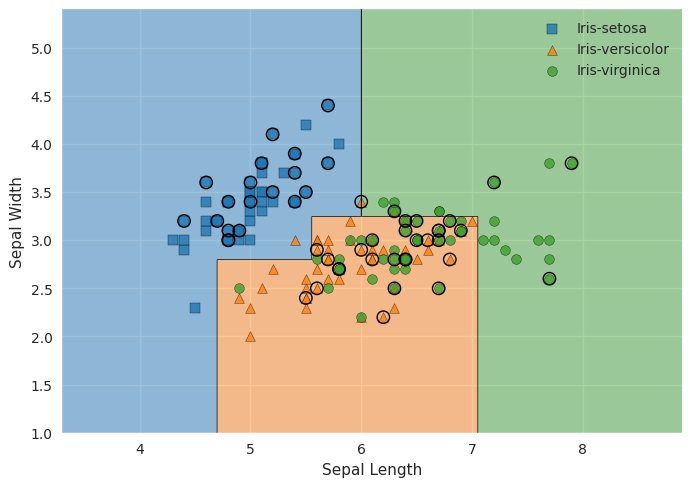

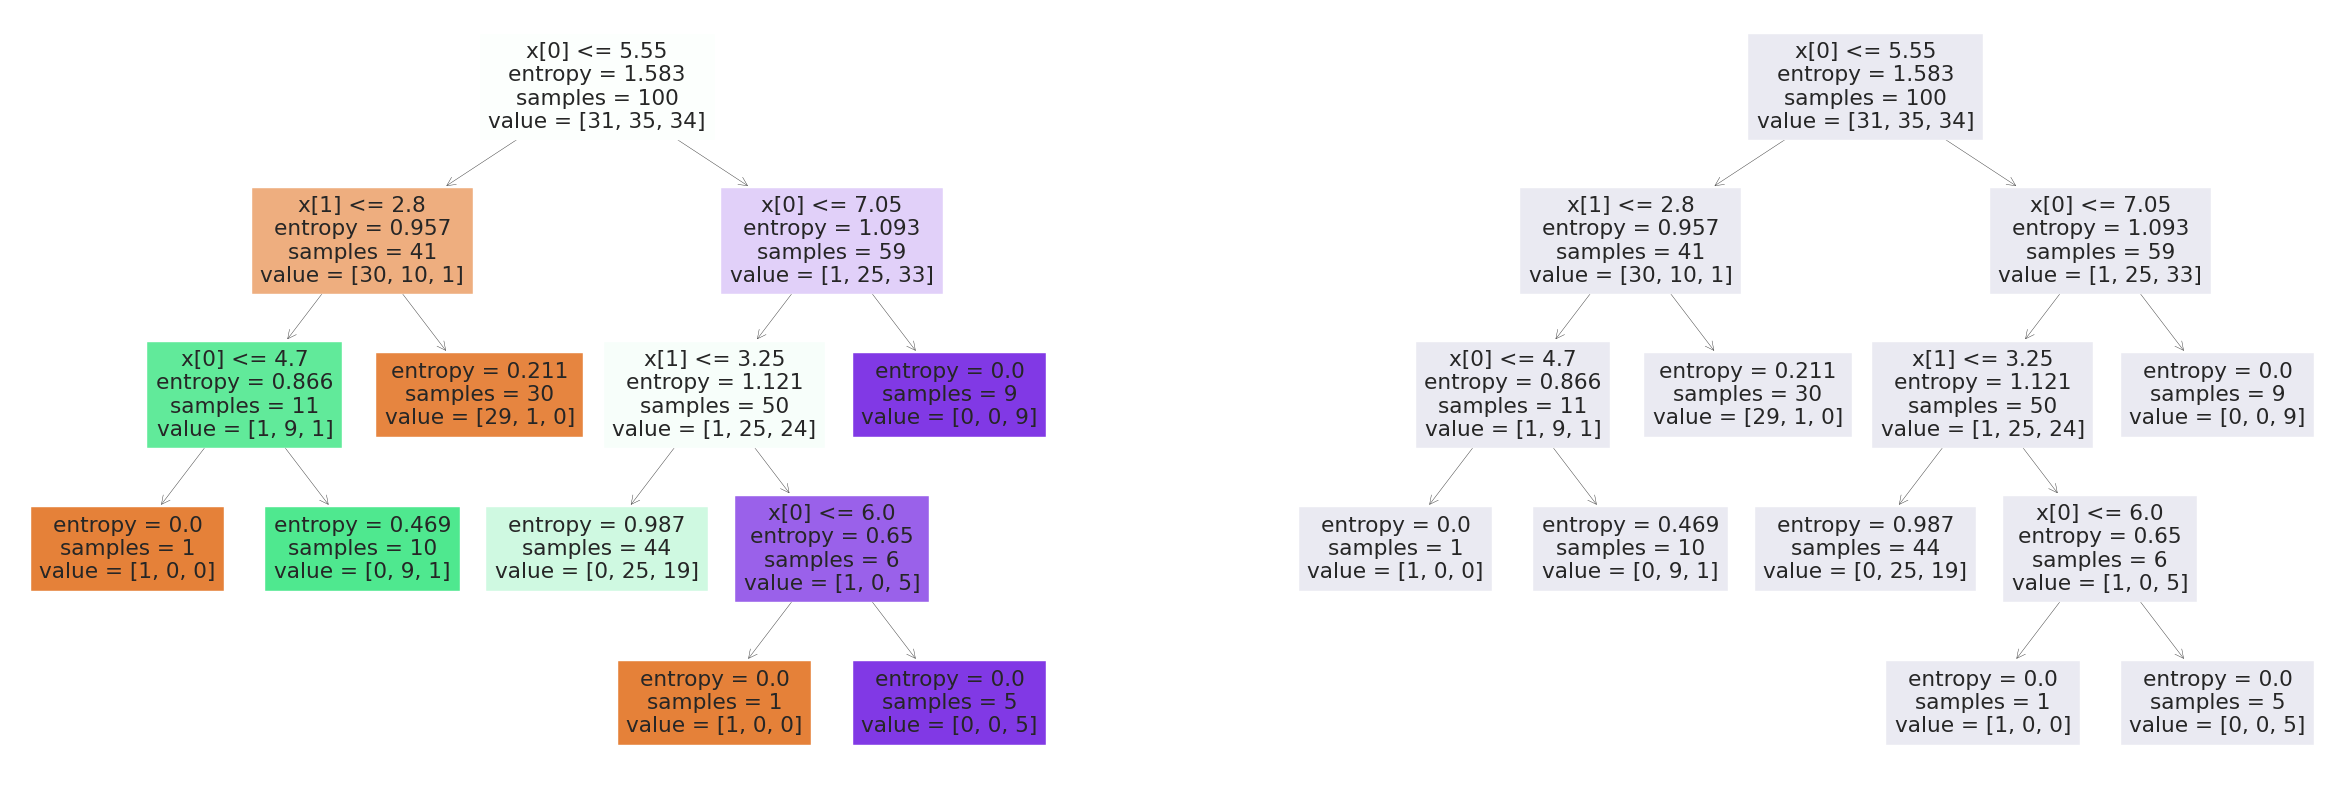

|--- feature_0 <= 5.55
|   |--- feature_1 <= 2.80
|   |   |--- feature_0 <= 4.70
|   |   |   |--- class: 0
|   |   |--- feature_0 >  4.70
|   |   |   |--- class: 1
|   |--- feature_1 >  2.80
|   |   |--- class: 0
|--- feature_0 >  5.55
|   |--- feature_0 <= 7.05
|   |   |--- feature_1 <= 3.25
|   |   |   |--- class: 1
|   |   |--- feature_1 >  3.25
|   |   |   |--- feature_0 <= 6.00
|   |   |   |   |--- class: 0
|   |   |   |--- feature_0 >  6.00
|   |   |   |   |--- class: 2
|   |--- feature_0 >  7.05
|   |   |--- class: 2

Avg accuracy:  0.7


In [13]:
df = pd.read_csv("datasets/iris.data.txt")

# It's considered only two columns
df_X = df.iloc[:, [0, 1]]
# Predict a categorical variable
encoder = LabelEncoder()
df_y = encoder.fit_transform(df["Class"])

X_train, X_test, Y_train, Y_test = train_test_split(
    df_X.values, df_y, test_size=0.33, random_state=random_state
)

# Post Pruning with i.e. max_leaf_nodes
dtc = DecisionTreeClassifier(criterion="entropy", ccp_alpha=0.0035, max_leaf_nodes=7)
dtc.fit(X_train, Y_train)

# Impurity-based feature importance
display(
    pd.DataFrame(
        {"Features": df_X.columns, "Importances": dtc.feature_importances_}
    ).sort_values("Importances", ascending=False)
)

# Plot the regions. For this reason we considered only two columns
# X_highlight=X_test : highlight test values
plot_decision_regions(df_X.values, df_y, clf=dtc, legend=2, X_highlight=X_test)
plt.xlabel(df_X.columns[0])
plt.ylabel(df_X.columns[1])
plt.legend(encoder.classes_)
plt.show()

# Tree representation: every leaf is a region
# first line: test condition of X_j variable to calculate regions boundaries
# second line: entropy/error
# third line: number of train samples fallen in this node
# fourth line: in which class the samples have fallen. If there are samples in more than one class, the node can further split
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))
tree.plot_tree(dtc, filled=True, ax=ax1)
tree.plot_tree(dtc, filled=False, ax=ax2)
plt.show()

# Text tree representation
text_representation = tree.export_text(dtc)
print(text_representation)

dtc.predict(X_test)
print("Avg accuracy: ", dtc.score(X_test, Y_test))

---
### Bagging
- To reduce the high variance (overfitting) of a tree, you can average a set of observations: 
    - Split the training set into several subsets
    - Train a decision tree on each subset, in an independent way
        - For Regression problems: average the predictions
        - For Classification problems: apply majority voting, i.e. return the class most commonly occurring among all tree results
- The subsets of Bagging Trees can still be correlated, because all subtrees will choose to split the same strong variables

### Random Forest
- To reduce the correlation among subtrees, RF forces each split to consider only $m<<p$ *random* variables, over the $p$ available variables
    - The final result is still the average/majority of the subtrees results
- They might be prone to overfitting and they reduce explainability

In [14]:
# -----------------------------------------------------
# Regression

df = pd.read_csv("datasets/iris.data.txt")

df_X = df.drop("Petal Length", axis=1)
# Predict a continuous variable
df_y = df["Petal Length"]

# Label Encoding
df_X["Class"] = LabelEncoder().fit_transform(df_X["Class"])

X_train, X_test, Y_train, Y_test = train_test_split(
    df_X.values, df_y, test_size=0.33, random_state=random_state
)

# RandomForestRegressor
# n_estimators: The number of trees in the forest
rf_reg = RandomForestRegressor(n_estimators=1000)
rf_reg.fit(X_train, np.ravel(Y_train))  # you need to flat the y_train

# Impurity-based feature importance
display(
    pd.DataFrame(
        {"Features": df_X.columns, "Importances": rf_reg.feature_importances_}
    ).sort_values("Importances", ascending=False)
)

rf_reg.predict(X_test)
print("Avg accuracy: ", rf_reg.score(X_test, Y_test))

,Features,Importances
3,Class,0.473428
2,Petal Width,0.472505
0,Sepal Length,0.047700
1,Sepal Width,0.006368


Avg accuracy:  0.9777301652256077


,Features,Importances
0,Sepal Length,0.636753
1,Sepal Width,0.363247


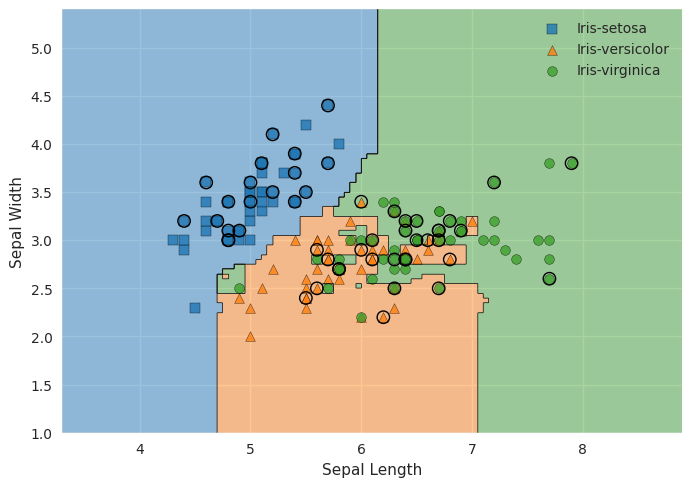

Avg accuracy:  0.74


In [15]:
# -----------------------------------------------------
# Classification

df = pd.read_csv("datasets/iris.data.txt")

# It's considered only two columns
df_X = df.iloc[:, [0, 1]]
# Predict a categorical variable
encoder = LabelEncoder()
df_y = encoder.fit_transform(df["Class"])

X_train, X_test, Y_train, Y_test = train_test_split(
    df_X.values, df_y, test_size=0.33, random_state=random_state
)

# RandomForestClassifier
# n_estimators: The number of trees in the forest
rf_class = RandomForestClassifier(n_estimators=1000)
rf_class.fit(X_train, np.ravel(Y_train))  # you need to flat the y_train

# Impurity-based feature importance
display(
    pd.DataFrame(
        {"Features": df_X.columns, "Importances": rf_class.feature_importances_}
    ).sort_values("Importances", ascending=False)
)

# Plot the regions
plot_decision_regions(df_X.values, df_y, clf=rf_class, legend=2, X_highlight=X_test)
plt.xlabel(df_X.columns[0])
plt.ylabel(df_X.columns[1])
plt.legend(encoder.classes_)
plt.show()

rf_class.predict(X_test)
print("Avg accuracy: ", rf_class.score(X_test, Y_test))

---
### Boosting
- It's a General Ensemble technique that allows to combine multiple predictor models
- Unlike Random Forests that construct all trees independently, boosting builds one tree at a time
- The goal is to create a strong model by iteratively improving upon a weak model. At each step, Boosting trains a new weak model to predict the error (actual minus predicted value) of the current strong model. The weak model’s prediction is added to the strong model with a negative sign to reduce the overall error. This iterative process continues until a stopping criterion is met (e.g., a maximum number of iterations or overfitting).

In [16]:
# -----------------------------------------------------
# Regression

df = pd.read_csv("datasets/iris.data.txt")

df_X = df.drop("Petal Length", axis=1)
# Predict a continuous variable
df_y = df["Petal Length"]

# Label Encoding
df_X["Class"] = LabelEncoder().fit_transform(df_X["Class"])

X_train, X_test, Y_train, Y_test = train_test_split(
    df_X.values, df_y, test_size=0.33, random_state=random_state
)

# GradientBoostingRegressor
# n_estimators: The number of trees in the forest
gb_reg = GradientBoostingRegressor(n_estimators=1000)
gb_reg.fit(X_train, np.ravel(Y_train))  # you need to flat the y_train

# Impurity-based feature importance
display(
    pd.DataFrame(
        {"Features": df_X.columns, "Importances": gb_reg.feature_importances_}
    ).sort_values("Importances", ascending=False)
)

gb_reg.predict(X_test)
print("Avg accuracy: ", gb_reg.score(X_test, Y_test))

,Features,Importances
2,Petal Width,0.586033
3,Class,0.357417
0,Sepal Length,0.051627
1,Sepal Width,0.004923


Avg accuracy:  0.96689685685245


,Features,Importances
0,Sepal Length,0.655016
1,Sepal Width,0.344984


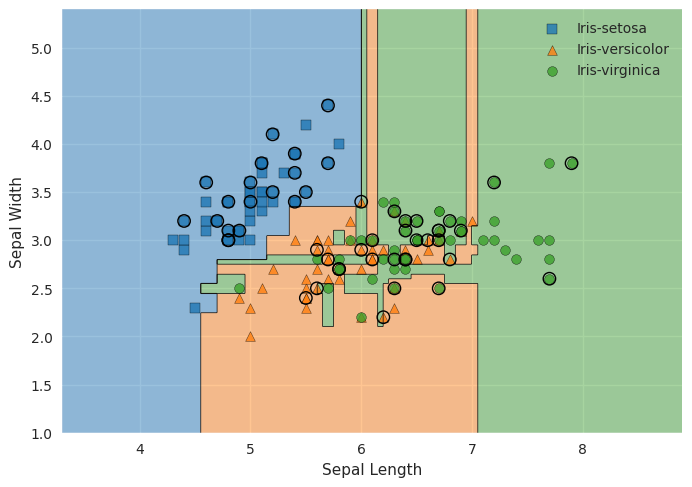

Avg accuracy:  0.7


In [17]:
# -----------------------------------------------------
# Classification

df = pd.read_csv("datasets/iris.data.txt")

# It's considered only two columns
df_X = df.iloc[:, [0, 1]]
# Predict a categorical variable
encoder = LabelEncoder()
df_y = encoder.fit_transform(df["Class"])

X_train, X_test, Y_train, Y_test = train_test_split(
    df_X.values, df_y, test_size=0.33, random_state=random_state
)

# GradientBoostingClassifier
# n_estimators: The number of boosting stages to perform
gb_class = GradientBoostingClassifier(n_estimators=1000)
gb_class.fit(X_train, Y_train)

# Impurity-based feature importance
display(
    pd.DataFrame(
        {"Features": df_X.columns, "Importances": gb_class.feature_importances_}
    ).sort_values("Importances", ascending=False)
)


# Plot the regions
plot_decision_regions(df_X.values, df_y, clf=gb_class, legend=2, X_highlight=X_test)
plt.xlabel(df_X.columns[0])
plt.ylabel(df_X.columns[1])
plt.legend(encoder.classes_)
plt.show()

gb_class.predict(X_test)
print("Avg accuracy: ", gb_class.score(X_test, Y_test))